In [3]:
#importing some stuff..
import os, time, sys
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [7]:
print('==> Preparing data..')


img_size = 64
#Just performing some transfomations on the image
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),
                             std=(0.5, 0.5, 0.5))
])

dataset_dir = 'data/resized'          # Change path according to your machine!
dataset = datasets.ImageFolder(dataset_dir, transform_train)
# data_loader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
temp = plt.imread(train_loader.dataset.imgs[0][0])
if (temp.shape[0] != img_size) or (temp.shape[0] != img_size):
    print ('Error! image size is not 64 x 64, run "lfw_preprocess.py" !!')
    sys.exit(1)

==> Preparing data..


In [34]:
#Hyper-Parameters--

#setting the learning rate
lr = 0.0002

#Number of samples to take a random distribution from
rand_num = 9

#Number of epochs
num_epoch = 20

#select min batch size
batch_size = 128

#Number of batches per Epoch
num_batches = len(train_loader)


if not os.path.isdir('LFW_DCGAN_results'):
    os.mkdir('LFW_DCGAN_results')

# Generator Network!

In [26]:
class generator(nn.Module):
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # Connecting the layers
    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x


# Discriminator Network

In [27]:
class discriminator(nn.Module):
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

In [28]:
# network
G = generator(128)
D = discriminator(128)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

#Initializing weights
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Define optimizers
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))



fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    #noise
fixed_z_ = Variable(fixed_z_, volatile=True)

In [29]:
def visualize(num_epoch, path):
    
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_, volatile=True)

    G.eval()
    test_images = G(fixed_z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow((test_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)


In [35]:
train_hist = {}
train_hist['D_losses'] = []                                #storing losses for each batch
train_hist['G_losses'] = []

print('Training..')

for epoch in range(num_epoch):
    D_losses = []                                           #storing losses for each batch
    G_losses = []
    
    num_iter = 0
    for images, _ in train_loader:
    
        mini_batch = images.size()[0]
        labels_real = Variable(torch.ones(mini_batch))       # Labels for real images - all ones
        labels_fake = Variable(torch.zeros(mini_batch))      # Labels for fake images - all zeros

        images = Variable(images)
        
        # Train the discriminator, it tries to discriminate between real and fake samples
        D.zero_grad()
        D_result = D(images).squeeze()
        D_real_loss = BCE_loss(D_result, labels_real)

        z_ = Variable(torch.randn((mini_batch, 100)).view(-1, 100, 1, 1))
        G_result = G(z_)
 
        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, labels_fake)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss        # Calculate the total loss

        D_train_loss.backward()                         #Backpropagation
        D_optimizer.step()                              #Update the weights

        D_losses.append(D_train_loss.data[0])

        # Train the generator, it tries to fool the discriminator
        G.zero_grad()
        
        # Draw samples from the input distribution and pass to generator
        z_ = Variable(torch.randn((mini_batch, 100)).view(-1, 100, 1, 1))
        
        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, labels_real)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data[0])

        num_iter += 1


    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), num_epoch, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    p = 'LFW_DCGAN_results/LFW_DCGAN_' + str(epoch + 1) + '.png'
    visualize((epoch+1), path=p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    


Training..
[1/20] - loss_d: 0.146, loss_g: 7.503
[2/20] - loss_d: 0.330, loss_g: 8.765
[3/20] - loss_d: 0.182, loss_g: 8.815
[4/20] - loss_d: 0.167, loss_g: 9.085
[5/20] - loss_d: 0.082, loss_g: 8.060
[6/20] - loss_d: 0.133, loss_g: 10.367
[7/20] - loss_d: 0.040, loss_g: 9.163
[8/20] - loss_d: 0.095, loss_g: 10.032
[9/20] - loss_d: 0.049, loss_g: 9.562
[10/20] - loss_d: 0.099, loss_g: 12.124
[11/20] - loss_d: 0.033, loss_g: 10.301
[12/20] - loss_d: 0.090, loss_g: 12.472
[13/20] - loss_d: 0.026, loss_g: 10.734
[14/20] - loss_d: 0.073, loss_g: 12.554
[15/20] - loss_d: 0.027, loss_g: 10.811
[16/20] - loss_d: 0.064, loss_g: 12.977
[17/20] - loss_d: 0.022, loss_g: 11.102
[18/20] - loss_d: 0.058, loss_g: 13.241
[19/20] - loss_d: 0.019, loss_g: 10.907
[20/20] - loss_d: 0.131, loss_g: 20.500


/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [36]:
import pickle
with open("LFW_DCGAN_results/genloss.pkl","wb") as f:
    pickle.dump(train_hist['G_losses'],f)

In [37]:
with open("LFW_DCGAN_results/disloss.pkl","wb") as f:
    pickle.dump(train_hist['D_losses'],f)

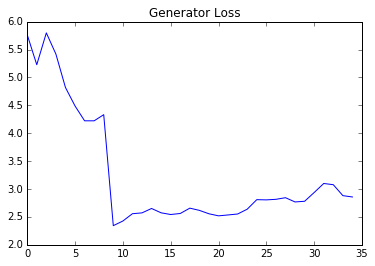

In [14]:
plt.plot(train_hist['G_losses'])
plt.title('Generator Loss')
plt.show()

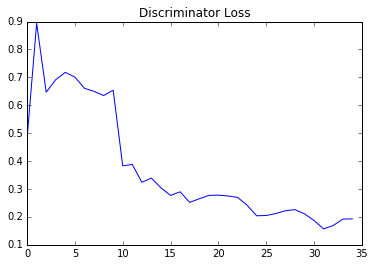

In [9]:
plt.plot(train_hist['D_losses'])
plt.title('Discriminator Loss')
plt.show()